In [39]:
import scipy
import numpy as np
import qptransform as qp
import matplotlib.pyplot as plt
from gwosc.datasets import event_gps
import warnings
warnings.filterwarnings("ignore")
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

# **GW150914 (BBH)**

## **Qp Transform**

In [40]:
event='GW150914-v3'
event_label='GW150914'
gps=event_gps(event)
dets=['L1','H1']
dets_label=['LIGO Livingston (L1)','LIGO Hanford (H1)']

denoising_threshold=7.
energy_density_threshold=7.

In [41]:
f_s=2048.
trange=[gps-.15, gps+.05]
frange=[20., 500.]
duration=trange[-1]-trange[0]
alpha=0.05
alpha_find_Qp=0.2
qrange=[2.*np.pi, 6.*np.pi]
filmethod='highpass_threshold_filtering'

In [42]:
segment=(gps-10, gps+10)
data_init = qp.TimeSeries.fetch_open_data('L1', *segment, verbose=True) # download data
data_init

Fetched 1 URLs from gwosc.org for [1126259452 .. 1126259473))
Reading data... [Done]


<TimeSeries([-1.11661830e-18, -1.10578056e-18, -1.06578088e-18,
             ..., -5.43098222e-19, -5.14140699e-19,
             -5.49796980e-19]
            unit=Unit(dimensionless),
            t0=<Quantity 1.12625945e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='Strain',
            channel=None)>

In [43]:
downsampling=int(np.ceil(np.ceil(1./(data_init.times.value[1]-data_init.times.value[0]))/f_s))
data_downsampled=scipy.signal.decimate(data_init, downsampling) # downsample data
times=np.arange(segment[0], segment[-1], 1./f_s)
data=qp.TimeSeries(data_downsampled, x0=times[0], dx=times[1]-times[0], copy=False)
data = data.whiten() # whiten data
data = data.crop(*trange) # crop data

In [44]:
QPINSTANCE=qp.QpTransform(data=data, times=data.times.value, whiten=False, frange=frange, alpha=alpha, alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod)
print(f'Q={round(QPINSTANCE.Q, 8)}\np={round(QPINSTANCE.p,8)}\npeak={QPINSTANCE.peak}\nenergy density={round(QPINSTANCE.energy_density,2)}\narea={round(QPINSTANCE.TF_area,2)}')

BESTQ = QPINSTANCE.Q
BESTP = QPINSTANCE.p

Q=10.35999837
p=0.1105228
peak={'energy': 71.96134373232317, 'time': 1126259462.416552, 'frequency': 169.63385774082056}
energy density=23.96
area=4.22


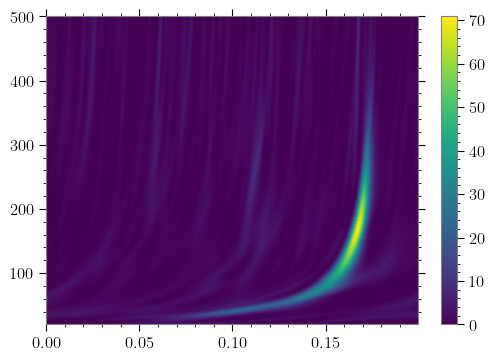

In [45]:
fig, ax = plt.subplots(figsize=(6, 4))
vmax=QPINSTANCE.qpspecgram.max()
ax.pcolormesh(QPINSTANCE.series.times.value-QPINSTANCE.series.times.value[0], QPINSTANCE.qpspecgram.frequencies.value, np.transpose(np.asarray(QPINSTANCE.qpspecgram.value)), vmin=0, vmax=vmax, cmap='viridis', shading='gouraud')
ax.colorbar = plt.colorbar(ax.get_children()[0], ax=ax, orientation='vertical')
ax.grid(False)

## **Trying different values of Q and p**

In [52]:
params_constant_q = {}
params_constant_q['Q'] = BESTQ
params_constant_q['p'] = []
params_constant_q['energy'] = []
params_constant_q['energy_density'] = []
params_constant_q['area'] = []
low_and_high_p = []
for p in np.linspace(0, 0.3, 30):
    qpinstance=qp.QpTransform(data=data, times=data.times.value, whiten=False, frange=frange, alpha=alpha, alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod, prange=[p,p], qrange=[BESTQ,BESTQ])
    params_constant_q['p'].append(p)
    params_constant_q['energy'].append(qpinstance.peak['energy'])
    params_constant_q['energy_density'].append(qpinstance.energy_density)
    params_constant_q['area'].append(qpinstance.TF_area)
    if p == 0 or p == 0.3:
        low_and_high_p.append(qpinstance)

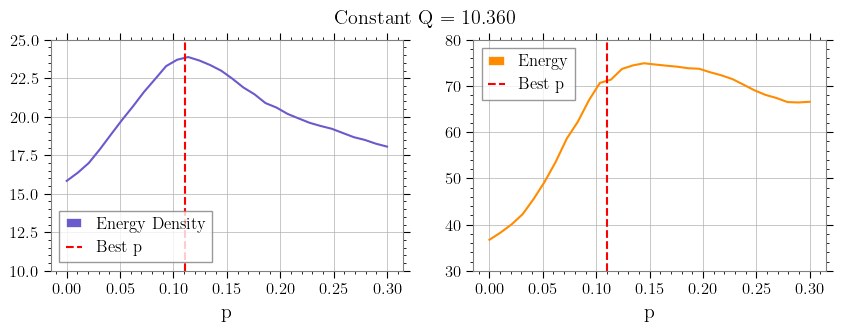

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(params_constant_q['p'], params_constant_q['energy_density'], label='Energy Density', color='slateblue')
ax[0].vlines(BESTP, 10, 25, color='red', linestyle='--', label='Best p')
ax[0].set_ylim(10, 25)
ax[0].set_xlabel('p')
ax[0].legend()

ax[1].plot(params_constant_q['p'], params_constant_q['energy'], label='Energy', color='darkorange')
ax[1].vlines(BESTP, 30, 80, color='red', linestyle='--', label='Best p')
ax[1].set_ylim(30, 80)
ax[1].set_xlabel('p')
ax[1].legend()

fig.suptitle(f'Constant Q = {BESTQ:.3f}')
fig.show()

In [58]:
params_constant_p = {}
params_constant_p['p'] = BESTP
params_constant_p['Q'] = []
params_constant_p['energy'] = []
params_constant_p['energy_density'] = []
params_constant_p['area'] = []
low_and_high_q = []
for q in np.linspace(5, 15, 50):
    qpinstance=qp.QpTransform(data=data, times=data.times.value, whiten=False, frange=frange, alpha=alpha, alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod, qrange=[q,q], prange=[BESTP,BESTP])
    params_constant_p['Q'].append(q)
    params_constant_p['energy'].append(qpinstance.peak['energy'])
    params_constant_p['energy_density'].append(qpinstance.energy_density)
    params_constant_p['area'].append(qpinstance.TF_area)
    if q == 5 or q == 15:
        low_and_high_q.append(qpinstance)

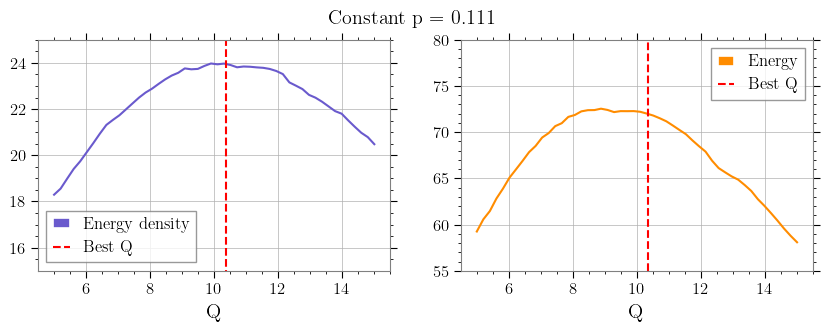

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(params_constant_p['Q'], params_constant_p['energy_density'], label='Energy density', color='slateblue')
ax[0].vlines(BESTQ, 0, 80, color='red', linestyle='--', label='Best Q')
ax[0].set_ylim(15, 25)
ax[0].set_xlabel('Q')
ax[0].legend()

ax[1].plot(params_constant_p['Q'], params_constant_p['energy'], label='Energy', color='darkorange')
ax[1].vlines(BESTQ, 55, 80, color='red', linestyle='--', label='Best Q')
ax[1].set_ylim(55, 80)
ax[1].set_xlabel('Q')
ax[1].legend()

fig.suptitle(f'Constant p = {BESTP:.3f}')
fig.show()

### **Comparing filtering with lower and higher values of p and q**

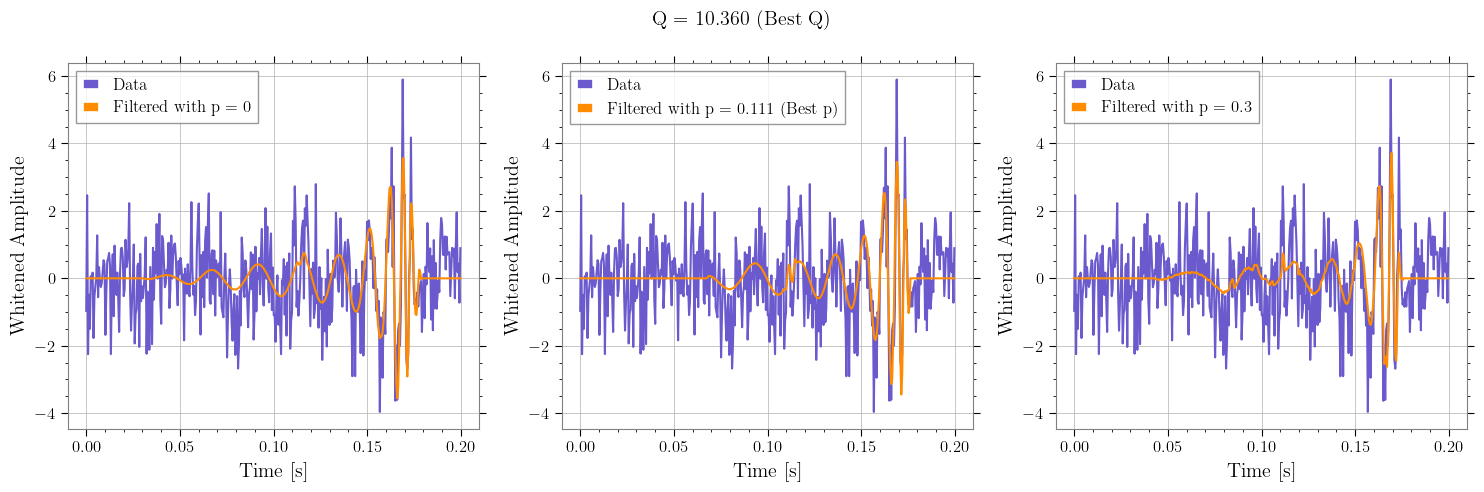

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(low_and_high_p[0].series.times.value-low_and_high_p[0].series.times.value[0], low_and_high_p[0].series.value, color='slateblue', label='Data')
ax[0].plot(low_and_high_p[0].filseries.times.value-low_and_high_p[0].filseries.times.value[0], low_and_high_p[0].filseries.value, color='darkorange', label=f'Filtered with p = 0')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Whitened Amplitude')
ax[0].legend()

ax[1].plot(QPINSTANCE.series.times.value-QPINSTANCE.series.times.value[0], QPINSTANCE.series.value, color='slateblue', label='Data')
ax[1].plot(QPINSTANCE.filseries.times.value-QPINSTANCE.filseries.times.value[0], QPINSTANCE.filseries.value, color='darkorange', label=f'Filtered with p = {BESTP:.3f} (Best p)')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Whitened Amplitude')
ax[1].legend()

ax[2].plot(low_and_high_p[1].series.times.value-low_and_high_p[1].series.times.value[0], low_and_high_p[1].series.value, color='slateblue', label='Data')
ax[2].plot(low_and_high_p[1].filseries.times.value-low_and_high_p[1].filseries.times.value[0], low_and_high_p[1].filseries.value, color='darkorange', label=f'Filtered with p = 0.3')
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('Whitened Amplitude')
ax[2].legend()

fig.suptitle(f'Q = {BESTQ:.3f} (Best Q)')
fig.tight_layout()
fig.show()

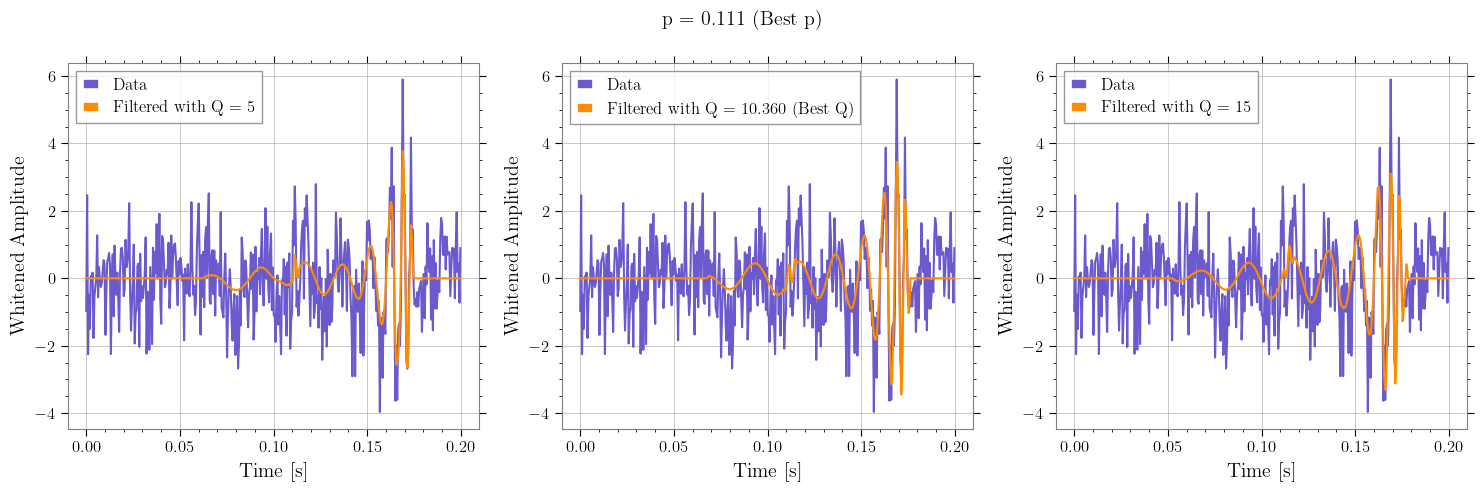

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(low_and_high_q[0].series.times.value-low_and_high_q[0].series.times.value[0], low_and_high_q[0].series.value, color='slateblue', label='Data')
ax[0].plot(low_and_high_q[0].filseries.times.value-low_and_high_q[0].filseries.times.value[0], low_and_high_q[0].filseries.value, color='darkorange', label=f'Filtered with Q = 5')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Whitened Amplitude')
ax[0].legend()

ax[1].plot(QPINSTANCE.series.times.value-QPINSTANCE.series.times.value[0], QPINSTANCE.series.value, color='slateblue', label='Data')
ax[1].plot(QPINSTANCE.filseries.times.value-QPINSTANCE.filseries.times.value[0], QPINSTANCE.filseries.value, color='darkorange', label=f'Filtered with Q = {BESTQ:.3f} (Best Q)')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Whitened Amplitude')
ax[1].legend()

ax[2].plot(low_and_high_q[1].series.times.value-low_and_high_q[1].series.times.value[0], low_and_high_q[1].series.value, color='slateblue', label='Data')
ax[2].plot(low_and_high_q[1].filseries.times.value-low_and_high_q[1].filseries.times.value[0], low_and_high_q[1].filseries.value, color='darkorange', label=f'Filtered with Q = 15')
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('Whitened Amplitude')
ax[2].legend()

fig.suptitle(f'p = {BESTP:.3f} (Best p)')
fig.tight_layout()
fig.show()

# **GW170817 (BNS)**

## **Qp Transform**

In [12]:
event = 'GW170817-v3'
event_label = 'GW170817'
gps = event_gps(event)
segment = (gps-20, gps+10)
dets=['L1','H1']
dets_label=['LIGO Livingston (L1)','LIGO Hanford (H1)']

denoising_threshold=7.
energy_density_threshold=7.

In [13]:
f_s=2048.
trange=[gps-1, gps+0.1]
frange=[20., 500.]

duration=trange[-1]-trange[0]
alpha=0.05
alpha_find_Qp=0.2
qrange=[20.*np.pi, 30.*np.pi]
filmethod='highpass_threshold_filtering'

In [14]:
data_init = qp.TimeSeries.fetch_open_data('H1', *segment, verbose=True) # download data
data_init

Fetched 1 URLs from gwosc.org for [1187008862 .. 1187008893))
Reading data... [Done]


<TimeSeries([-5.30648354e-19, -5.40632220e-19, -5.54840192e-19,
             ..., -4.66441411e-19, -4.65560015e-19,
             -4.51069234e-19]
            unit=Unit(dimensionless),
            t0=<Quantity 1.18700886e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='Strain',
            channel=None)>

In [15]:
downsampling=int(np.ceil(np.ceil(1./(data_init.times.value[1]-data_init.times.value[0]))/f_s))
data_downsampled=scipy.signal.decimate(data_init, downsampling) # downsample data
times=np.arange(segment[0], segment[-1], 1./f_s)
data=qp.TimeSeries(data_downsampled, x0=times[0], dx=times[1]-times[0], copy=False)
data = data.whiten() # whiten data
data = data.crop(*trange) # crop data

In [16]:
QPINSTANCE=qp.QpTransform(data=data, times=data.times.value, whiten=False, frange=frange, alpha=alpha, alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold, qrange=qrange, filmethod=filmethod)
print(f'Q={round(QPINSTANCE.Q, 8)}\np={round(QPINSTANCE.p,8)}\npeak={QPINSTANCE.peak}\nenergy density={round(QPINSTANCE.energy_density,2)}\narea={round(QPINSTANCE.TF_area,2)}')

BESTQ = QPINSTANCE.Q
BESTP = QPINSTANCE.p

Q=78.66729603
p=0.01591549
peak={'energy': 24.999464561441734, 'time': 1187008882.1105647, 'frequency': 202.71790007220127}
energy density=11.91
area=5.88


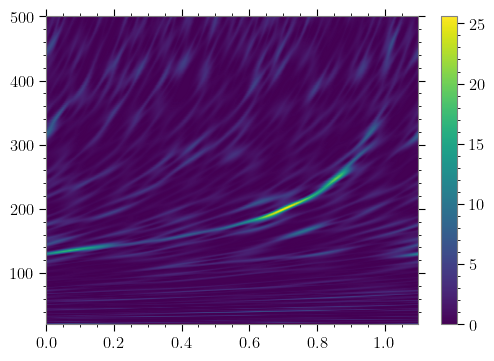

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
vmax=QPINSTANCE.qpspecgram.max()
ax.pcolormesh(QPINSTANCE.series.times.value-QPINSTANCE.series.times.value[0], QPINSTANCE.qpspecgram.frequencies.value, np.transpose(np.asarray(QPINSTANCE.qpspecgram.value)), vmin=0, vmax=vmax, cmap='viridis', shading='gouraud')
ax.colorbar = plt.colorbar(ax.get_children()[0], ax=ax, orientation='vertical')
ax.grid(False)

## **Trying different values of Q and p**

In [19]:
params_constant_q = {}
params_constant_q['Q'] = BESTQ
params_constant_q['p'] = []
params_constant_q['energy'] = []
params_constant_q['energy_density'] = []
params_constant_q['area'] = []
for p in np.linspace(0, 0.1, 50):
    qpinstance=qp.QpTransform(data=data, times=data.times.value, whiten=False, frange=frange, alpha=alpha, alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod, prange=[p,p], qrange=[BESTQ,BESTQ])
    params_constant_q['p'].append(p)
    params_constant_q['energy'].append(qpinstance.peak['energy'])
    params_constant_q['energy_density'].append(qpinstance.energy_density)
    params_constant_q['area'].append(qpinstance.TF_area)

/tmp/ipykernel_2467878/110683398.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


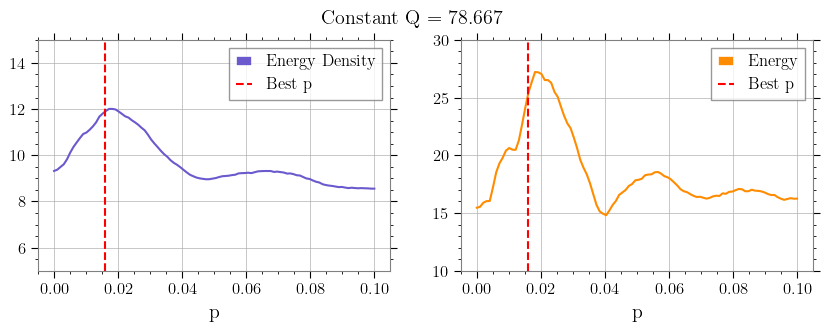

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(params_constant_q['p'], params_constant_q['energy_density'], label='Energy Density', color='slateblue')
ax[0].vlines(BESTP, 5, 15, color='red', linestyle='--', label='Best p')
ax[0].set_ylim(5, 15)
ax[0].set_xlabel('p')
ax[0].legend()

ax[1].plot(params_constant_q['p'], params_constant_q['energy'], label='Energy', color='darkorange')
ax[1].vlines(BESTP, 10, 30, color='red', linestyle='--', label='Best p')
ax[1].set_ylim(10, 30)
ax[1].set_xlabel('p')
ax[1].legend()

fig.suptitle(f'Constant Q = {BESTQ:.3f}')
fig.show()

In [30]:
params_constant_p = {}
params_constant_p['p'] = BESTP
params_constant_p['Q'] = []
params_constant_p['energy'] = []
params_constant_p['energy_density'] = []
params_constant_p['area'] = []
for q in np.linspace(70, 90, 50):
    qpinstance=qp.QpTransform(data=data, times=data.times.value, whiten=False, frange=frange, alpha=alpha, alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod, qrange=[q,q], prange=[BESTP,BESTP])
    params_constant_p['Q'].append(q)
    params_constant_p['energy'].append(qpinstance.peak['energy'])
    params_constant_p['energy_density'].append(qpinstance.energy_density)
    params_constant_p['area'].append(qpinstance.TF_area)

/tmp/ipykernel_2467878/2139182734.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


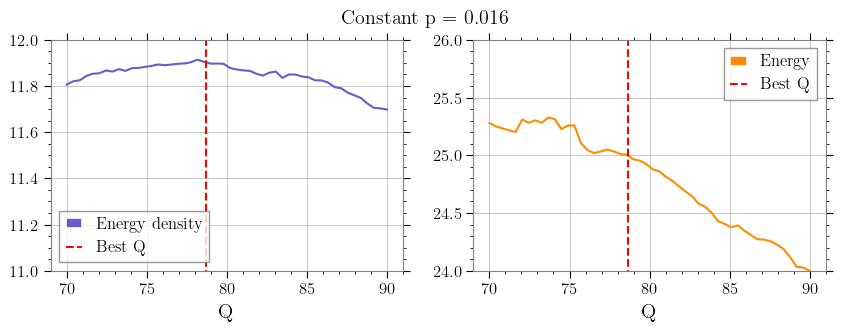

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(params_constant_p['Q'], params_constant_p['energy_density'], label='Energy density', color='slateblue')
ax[0].vlines(BESTQ, 10, 15, color='red', linestyle='--', label='Best Q')
ax[0].set_ylim(11, 12)
ax[0].set_xlabel('Q')
ax[0].legend()

ax[1].plot(params_constant_p['Q'], params_constant_p['energy'], label='Energy', color='darkorange')
ax[1].vlines(BESTQ, 20, 30, color='red', linestyle='--', label='Best Q')
ax[1].set_ylim(24, 26)
ax[1].set_xlabel('Q')
ax[1].legend()

fig.suptitle(f'Constant p = {BESTP:.3f}')
fig.show()